In [9]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot

%matplotlib inline

In [2]:
data = pd.read_table('http://health.bsd.uchicago.edu/yji/Bayes2017/Homework/logit.txt', header=None, sep='\s+')
data.columns = ['x', 'y']

In [116]:
X = data['x'].values.reshape((-1, 1))
Y = data['y'].values.reshape((-1, 1))

X2 = X ** 2  # precompute
X1 = np.concatenate([np.ones_like(X), X], axis=1)
X12 = np.concatenate([X1, X2], axis=1)

num_samples = 150000
m = np.ones(num_samples)
h = 0.5

beta01 = np.ones((num_samples, 2))
beta2 = np.zeros((num_samples, 1))

std_beta = np.sqrt(10)
std_u = np.sqrt(1)
tau = np.sqrt(0.05)

num_obs = len(data)

In [117]:
def sample01(b01, data, dataY_):
    curr = b01
    prop = curr + stats.norm(0, tau).rvs(2)
    # Ratio
    like_ratio = LLK(curr, prop, 1, 1, data, dataY_, 'sample 1')
    prior_ratio = np.sum(np.log(stats.norm(0, std_beta).pdf(prop))) -\
                  np.sum(np.log(stats.norm(0, std_beta).pdf(curr)))
        
    acp = like_ratio + prior_ratio
    if acp > np.log(np.random.uniform()):
        return prop
    else:
        return curr


def sample012(b01, b2, data, dataY_):
    curr = np.concatenate([b01, b2])
    prop = curr + stats.norm(0, tau).rvs(3)

    like_ratio = LLK(curr, prop, 2, 2, data, dataY_, 'sample 2')

    prior_ratio = np.sum(np.log(stats.norm(0, std_beta).pdf(prop))) - \
                  np.sum(np.log(stats.norm(0, std_beta).pdf(curr)))

    acp = like_ratio + prior_ratio
    if acp > np.log(np.random.uniform()):
        return prop
    else:
        return curr


def LLK(currBeta, propBeta, modelCurr, modelProp, data, dataY, name):
    
    if modelCurr == 1:
        currBeta2 = 0
    else:
        currBeta2 = currBeta[2]

    if modelProp == 1:
        propBeta2 = 0
    else:
        propBeta2 = propBeta[2]

    like_ratio = np.sum(dataY * (propBeta[0] + propBeta[1] * X1 + propBeta2 * X2 - currBeta[0] - currBeta[1] - currBeta2 * X2) +\
                        np.log(1 + np.exp(currBeta[0] + currBeta[1] + currBeta2 * X2)) -\
                        np.log(1 + np.exp(propBeta[0] + propBeta[1] * X1 + propBeta2 * X2)))

    return like_ratio

In [118]:
for sim in tqdm.trange(num_samples - 1):

    if m[sim] == 1:

        chg_ind = np.random.rand() < h

        if chg_ind:

            u = stats.norm(0, std_u).rvs(1)
            beta2_tmp = u
            beta012_prop = np.concatenate([beta01[sim], beta2_tmp])

            like_ratio = LLK(beta01[sim], beta012_prop, 1, 2, X12, Y, 'add var')
            prior_ratio = stats.norm.logpdf(beta2_tmp, 0, std_beta)
            proposal = stats.norm.logpdf(u, 0, std_u)
            acc = like_ratio + prior_ratio + proposal
            ind = acc > np.log(np.random.rand())

            if ind:
                m[sim + 1] = 2
                beta2[sim + 1] = beta2_tmp
                beta01[sim + 1] = beta01[sim]
            else:
                m[sim + 1] = m[sim]
                beta2[sim + 1] = 0.0
                beta01[sim + 1] = beta01[sim]

        else:
            sample = sample01(beta01[sim], X12, Y)
            beta01[sim + 1] = sample
            beta2[sim + 1] = 0.0  # beta2[sim]
            m[sim + 1] = m[sim]

    else:
        chg_ind = np.random.rand() < h

        if chg_ind:

            u = beta2[sim]
            beta2_tmp = beta2[sim]
            beta012_prop = np.concatenate([beta01[sim], beta2_tmp])

            like_ratio = LLK(beta012_prop, beta01[sim], 2, 1, X12, Y, 'drop var')
            prior_ratio = np.log(stats.norm.pdf(beta2_tmp, loc=0, scale=std_beta))
            proposal = np.log(stats.norm.pdf(u, 0, std_u))
            acc = like_ratio + prior_ratio - proposal

            ind = acc > np.log(np.random.rand())

            if ind:
                m[sim + 1] = 1
                beta2[sim + 1] = 0.
                beta01[sim + 1] = beta01[sim]

            else:
                m[sim + 1] = m[sim]
                
                beta01[sim + 1] = beta01[sim]
                beta2[sim + 1] = beta2[sim]

        else:
#             print 'here'
            sample = sample012(beta01[sim], beta2[sim], X12, Y)
            beta01[sim + 1] = sample[:2]
            beta2[sim + 1] = sample[2]
            m[sim + 1] = m[sim]

100%|██████████| 149999/149999 [05:13<00:00, 478.95it/s]


In [119]:
burnedValues = np.hstack([beta01, beta2])[5000::15]

In [59]:
print 'Means'
print '   Beta 0  ', '     Beta 1  ', '   Beta 2'
print burnedValues.mean(axis=0)

Means
   Beta 0        Beta 1      Beta 2
[-1.77196154 -0.03384671  0.34157622]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


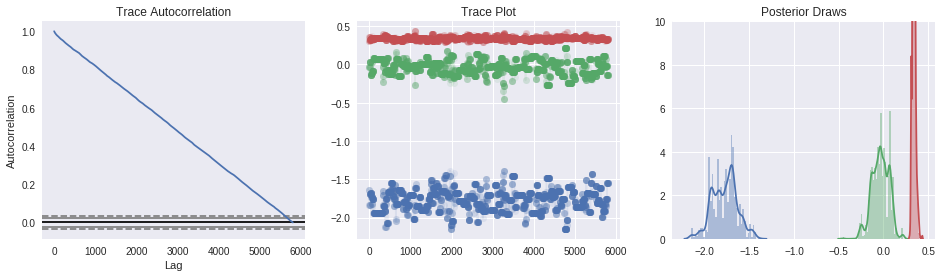

In [64]:
plt.figure(figsize=(16, 4))
_ = plt.subplot(131)
autocorrelation_plot(burnedValues, ax=_)
# plt.ylim([-.25, .25])
plt.title('Trace Autocorrelation')
plt.subplot(132).plot(burnedValues, '-o', alpha=0.1)
plt.title('Trace Plot')
ax = plt.subplot(133)
sns.distplot(burnedValues[:,0], ax=ax, bins=40, color=sns.color_palette()[0])
sns.distplot(burnedValues[:,1], ax=ax, bins=40, color=sns.color_palette()[1])
sns.distplot(burnedValues[:,2], ax=ax, bins=40, color=sns.color_palette()[2])
plt.ylim(0,10)
plt.legend()
plt.title('Posterior Draws');

In [98]:
def logit(b, xp):
    exp = np.exp(b[:, 0] + b[:, 1] * xp)
    rv = exp /(1 + exp)
    return rv
# f2 = lambda b, xp: np.exp(b*xp)/(1 + np.exp(b*X12))

In [79]:
X.shape

(1000, 1)

In [93]:
X.shape

(1000, 1)

In [99]:
pred01 = logit(beta01, X)

(1000, 60000)


(50, 580)


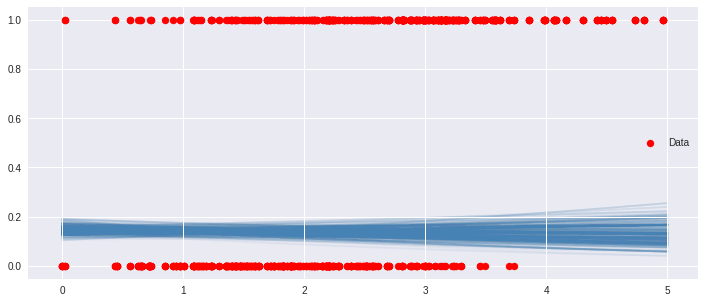

In [115]:
  # Numpy version of invlogit

xp = np.linspace(0, 5, 50)[:, None]  # sample values
a = -3.
# b = burnedValues[::10, None].T  # Posterior values
mu = b.mean(axis=1)
plt.figure(figsize=(12, 5))
plt.plot(xp, logit(burnedValues[::10],xp), color='steelblue', alpha=0.05, zorder=0)
# plt.plot(xp, f(a, mu, xp), color='gold', label='Post-Mean', lw=3, zorder=1)
plt.scatter(X, Y, s=50, color='r', label='Data', zorder=2)
# plt.xlabel('Drug Dosage Level')
# plt.ylabel('Risk of Toxicity')
plt.legend();